In [7]:
import os
import geopandas as gpd
 
if not os.path.exists("covid.geojson"):
    print("download")
    df = gpd.read_file("https://opendata.arcgis.com/datasets/559d482bad0643f69cbe1538243e0baa_9.geojson")
    df.to_file("covid.geojson", index=False)
df = gpd.read_file("covid.geojson")
df.head() # df.plot()

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,ShapeSTArea,ShapeSTLength,geometry
0,2022-04-07T19:00:00+00:00,55079000101,None,1158,0,0.14,24,0,0.0,0,...,511,568,2022-04-06T06:00:00+00:00,4476,437.0,260,Census tract,7.500609e+06,11159.571995,"POLYGON ((-87.99418 43.19256, -87.99429 43.192..."
1,2022-04-07T19:00:00+00:00,55079000102,None,1159,1,0.43,19,0,0.0,0,...,561,508,2022-04-06T06:00:00+00:00,3468,404.0,261,Census tract,1.224474e+07,15500.211793,"POLYGON ((-87.99449 43.17769, -87.99512 43.177..."
2,2022-04-07T19:00:00+00:00,55079000201,None,1410,0,0.29,10,0,0.0,0,...,722,609,2022-04-06T06:00:00+00:00,5561,699.0,262,Census tract,1.488298e+07,17849.912522,"POLYGON ((-88.02435 43.17761, -88.02434 43.177..."
3,2022-04-07T19:00:00+00:00,55079000202,None,1728,0,0.71,11,0,0.0,0,...,913,738,2022-04-06T06:00:00+00:00,6439,621.0,263,Census tract,1.480524e+07,17742.064041,"POLYGON ((-88.02435 43.17761, -88.02518 43.177..."
4,2022-04-07T19:00:00+00:00,55079000301,None,411,1,0.14,4,0,0.0,0,...,218,172,2022-04-06T06:00:00+00:00,1485,92.0,264,Census tract,3.733793e+06,9142.114479,"POLYGON ((-88.05488 43.14699, -88.05511 43.146..."


In [8]:
df.replace(-999, 2, inplace=True) # based on docs

In [10]:
df = df[df["GEOID"].str.fullmatch(r"\d+")]

<AxesSubplot:>

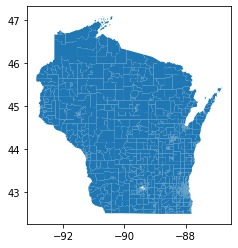

In [6]:
df.plot()

In [11]:
df["POS_CUM_CP"].sum()

1548846

In [12]:
df["DTH_CUM_CP"].sum()


13934

In [13]:
df["DTH_CUM_CP"].sum() / df["POS_CUM_CP"].sum()

0.008996375365917592

In [15]:
xcols = ["POP"]
df[xcols].head()
ycol = "DTH_CUM_CP"
df[ycol].head()

0    24
1    19
2    10
3    11
4     4
Name: DTH_CUM_CP, dtype: int64

In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df[xcols], df[ycol])
predictions = pd.DataFrame({"POP": [1000, 2000]})
predictions["y"] = model.predict(predictions[xcols])
predictions


,POP,y
0,1000,3.627988
1,2000,5.653305


<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

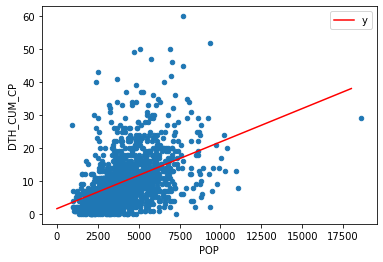

In [18]:
predictions = pd.DataFrame({"POP": range(0, 18000)})
predictions["y"] = model.predict(predictions[xcols])
ax = predictions.plot.line(x="POP", y="y", color="red")
df.plot.scatter(x="POP", y="DTH_CUM_CP", ax=ax)

In [19]:
f"deaths = {model.coef_[0]} * population + {model.intercept_}"

'deaths = 0.00202531765994764 * population + 1.6026699609658888'

In [26]:
before = df["DTH_CUM_CP"].var()
before

64.45856160704695

In [27]:
after = (df["DTH_CUM_CP"] - model.predict(df[xcols])).var()
after

51.94852682334216

In [28]:
reduction = before - after
reduction

12.510034783704782

In [29]:
reduction / before

0.19407871463171342

In [30]:
model.score(df[xcols], df[ycol])

0.19407871463171344

In [32]:
train = df[:len(df)//2]
test = df[len(df)//2:]

model.fit(train[xcols], train[ycol])
model.score(test[xcols], test[ycol])

0.17161195182490563

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
train, test = train_test_split(df)

model.fit(train[xcols], train[ycol])
model.score(test[xcols], test[ycol])

0.18147364564695156

In [44]:
pop_model_scores = cross_val_score(model, train[xcols], train[ycol])
pop_model_scores

array([ 0.22222033,  0.25025762,  0.11647802, -0.0226187 ,  0.25480978])

In [46]:
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'TESTS_POS_CONF',
       'TESTS_POS_CONF_NEW', 'TESTS_POS_CONF_7DAYAVG', 'PercentNAATPos',
       'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG', 'POS_CUM_CONF',
       'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB', 'POS_NEW_PROB',
       'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF', 'DTH_7DAYAVG_CONF',
       'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB', 'DTH_7DAYAVG_PROB',
       'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP', 'POS_OTH_CP',
       'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP', 'DTHS_MALE_CP',
       'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP', 'DTHS_20_29_CP',
       'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP', 'DTHS_60_69_CP',
       'DTH

In [47]:
xcols = ["POS_CUM_CP"]
ycol = "DTH_CUM_CP"
model2 = LinearRegression()
cases_model_scores = cross_val_score(model2, df[xcols], df[ycol])
cases_model_scores

array([0.2736876 , 0.2919447 , 0.11989205, 0.1418976 , 0.34284083])

<AxesSubplot:>

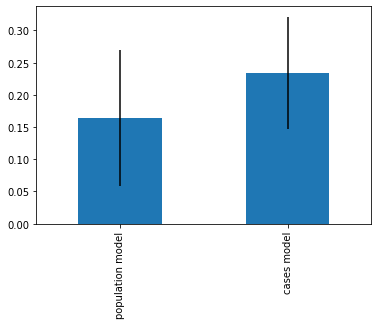

In [52]:
scores = pd.Series({"population model": pop_model_scores.mean(),
                    "cases model": cases_model_scores.mean()})
dev = pd.Series({"population model": pop_model_scores.std(),
                  "cases model": cases_model_scores.std()})

scores.plot.bar(yerr=dev)

In [54]:
model2.fit(test[xcols], test[ycol])
model2.score(test[xcols], test[ycol])

0.22569500099053608

In [55]:
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'TESTS_POS_CONF',
       'TESTS_POS_CONF_NEW', 'TESTS_POS_CONF_7DAYAVG', 'PercentNAATPos',
       'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG', 'POS_CUM_CONF',
       'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB', 'POS_NEW_PROB',
       'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF', 'DTH_7DAYAVG_CONF',
       'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB', 'DTH_7DAYAVG_PROB',
       'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP', 'POS_OTH_CP',
       'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP', 'DTHS_MALE_CP',
       'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP', 'DTHS_20_29_CP',
       'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP', 'DTHS_60_69_CP',
       'DTH

In [57]:
xcols = ['POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP']
model = LinearRegression()
cross_val_score(model, train[xcols], train[ycol])

array([0.70563998, 0.69202626, 0.68904396, 0.57292001, 0.75496672])

In [59]:
model.fit(train[xcols], train[ycol])
model.coef_

array([-0.02885867,  0.00034528, -0.00077734,  0.01706248,  0.00860453,
       -0.00663749,  0.00789109,  0.02340222,  0.16720632,  0.31577997])

<AxesSubplot:>

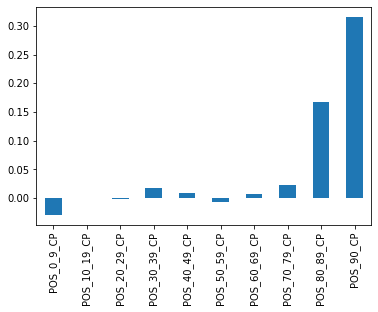

In [60]:
pd.Series(model.coef_, index=xcols).plot.bar()

In [61]:
model.intercept_

0.7234300315679647

In [62]:
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'TESTS_POS_CONF',
       'TESTS_POS_CONF_NEW', 'TESTS_POS_CONF_7DAYAVG', 'PercentNAATPos',
       'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG', 'POS_CUM_CONF',
       'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB', 'POS_NEW_PROB',
       'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF', 'DTH_7DAYAVG_CONF',
       'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB', 'DTH_7DAYAVG_PROB',
       'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP', 'POS_OTH_CP',
       'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP', 'DTHS_MALE_CP',
       'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP', 'DTHS_20_29_CP',
       'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP', 'DTHS_60_69_CP',
       'DTH

In [65]:
df.area

/tmp/ipykernel_82485/2704296042.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df.area


0       0.000441
1       0.000721
2       0.000876
3       0.000871
4       0.000220
          ...   
1388    0.062779
1389    0.030203
1390    0.020349
1391    0.030825
1392    0.030934
Length: 1392, dtype: float64

In [66]:
df.set_index("GEOID", inplace=True)
df.head()

,RptDt,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,DTH_CP_Daily,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,ShapeSTArea,ShapeSTLength,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
55079000101,2022-04-07T19:00:00+00:00,None,1158,0,0.14,24,0,0.0,0,0,...,511,568,2022-04-06T06:00:00+00:00,4476,437.0,260,Census tract,7.500609e+06,11159.571995,"POLYGON ((-87.99418 43.19256, -87.99429 43.192..."
55079000102,2022-04-07T19:00:00+00:00,None,1159,1,0.43,19,0,0.0,0,0,...,561,508,2022-04-06T06:00:00+00:00,3468,404.0,261,Census tract,1.224474e+07,15500.211793,"POLYGON ((-87.99449 43.17769, -87.99512 43.177..."
55079000201,2022-04-07T19:00:00+00:00,None,1410,0,0.29,10,0,0.0,0,0,...,722,609,2022-04-06T06:00:00+00:00,5561,699.0,262,Census tract,1.488298e+07,17849.912522,"POLYGON ((-88.02435 43.17761, -88.02434 43.177..."
55079000202,2022-04-07T19:00:00+00:00,None,1728,0,0.71,11,0,0.0,0,0,...,913,738,2022-04-06T06:00:00+00:00,6439,621.0,263,Census tract,1.480524e+07,17742.064041,"POLYGON ((-88.02435 43.17761, -88.02518 43.177..."
55079000301,2022-04-07T19:00:00+00:00,None,411,1,0.14,4,0,0.0,0,0,...,218,172,2022-04-06T06:00:00+00:00,1485,92.0,264,Census tract,3.733793e+06,9142.114479,"POLYGON ((-88.05488 43.14699, -88.05511 43.146..."


In [68]:
vac = gpd.read_file("https://opendata.arcgis.com/datasets/d1900c4a817d4b49940373f7ad934822_2.geojson")
vac.head()

DriverError: '/vsimem/4686a1b549cb463888a8920a0864b0a4' not recognized as a supported file format.